In [24]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

# internal imports
from tgb.utils.utils import *
from tgb.linkproppred.evaluate import Evaluator
from modules.decoder import LinkPredictorTGNPL
from modules.emb_module import GraphAttentionEmbedding
from modules.msg_func import TGNPLMessage
from modules.msg_agg import MeanAggregator
from modules.neighbor_loader import LastNeighborLoaderTGNPL
from modules.memory_module import TGNPLMemory, StaticMemory
from modules.early_stopping import  EarlyStopMonitor
from modules.hyper_edgebank import HyperEdgeBankPredictor, test_edgebank
from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset, PyGLinkPropPredDatasetHyper
from tgnpl import *

from scipy.stats import pearsonr

from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialize data and EdgeBank
Borrowed from test_model_training.ipynb

In [3]:
# recreate args
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
args = Namespace(dataset='tgbl-hypergraph',
                 lr=1e-4,
                 bs=2000,  # use larger batch size since we're not training
                 k_value=10,
                 num_epoch=100,
                 seed=1,
                 mem_dim=100,
                 time_dim=10,
                 emb_dim=100,
                 tolerance=1e-6,
                 patience=100,
                 num_run=1,
                 wandb=False,
                 bipartite=False,
                 memory_name='static',
                 emb_name='sum',
                 use_inventory=False,
                 debt_penalty=0,
                 consum_rwd=0,
                 gpu=0,
                 num_train_days=-1)
device = torch.device("cpu")

In [4]:
# Initialize dataset - copied from run_experiment() in tgnpl.py
with open(os.path.join(PATH_TO_DATASETS, f"{args.dataset.replace('-', '_')}/{args.dataset}_meta.json"), "r") as f:
    metadata = json.load(f)
# set global data variables
num_nodes = len(metadata["id2entity"])  
num_firms = metadata["product_threshold"]
num_products = num_nodes - num_firms              
dataset = PyGLinkPropPredDatasetHyper(name=args.dataset, root="datasets")
metric = dataset.eval_metric
neg_sampler = dataset.negative_sampler
evaluator = Evaluator(name=args.dataset)
data = dataset.get_TemporalData().to(device)
train_loader, val_loader, test_loader = split_data(args, data, dataset)

dataset.load_val_ns()  # load validation negative samples

Dataset tgbl-hypergraph url not found, download not supported yet.
file found, skipping download
Dataset directory is  /lfs/turing1/0/zhiyinl/supply-chains/TGB/tgb/datasets/tgbl_hypergraph
loading processed file
Train: N=214674, 273 days; Val: N=44991, 45 days; Test: N=45612, 47 days


In [5]:
# try with subset of train
# initialize edgebank, fit on train
edgebank = HyperEdgeBankPredictor(num_firms, num_products, consecutive=True)
train_days = data.t[dataset.train_mask].unique()  # original set of train days
days_to_keep = train_days[-30:]  # keep train days from the end, since val follows train
new_train_mask = torch.isin(data.t, days_to_keep)
print(new_train_mask.sum())
edgebank.fit(data[new_train_mask].src, data[new_train_mask].dst, data[new_train_mask].prod)

tensor(30157)
Fit on 30157 edges; found 12434 unique


In [6]:
exist_baseline = test_edgebank(val_loader, neg_sampler, "val", evaluator, metric, edgebank, use_counts=False)
count_baseline = test_edgebank(val_loader, neg_sampler, "val", evaluator, metric, edgebank, use_counts=True)
print(exist_baseline, count_baseline)

100%|███████████████████████████████████████████| 23/23 [00:05<00:00,  4.49it/s]

0.4436224400997162 0.6085948348045349


# Static and TGNPL Memory Analysis
We use last 30 days of train data for year 2019, tgnpl_id and static_id model provided by Serina. 

In [16]:
STATIC_PATH = "/lfs/turing1/0/serinac/supply-chains/TGB/examples/linkproppred/general/saved_models/TGNPL_tgbl-hypergraph_0.0003_1000_10_1000_1_100_10_100_1e-06_1000.0_1_False_False_static_id_False_0_0_2__30_False_2023_09_18-07_32_27_0.pth"
TGNPL_PATH = "/lfs/turing1/0/serinac/supply-chains/TGB/examples/linkproppred/general/saved_models/TGNPL_tgbl-hypergraph_0.001_800_10_1000_1_100_10_100_1e-06_1000.0_1_False_False_tgnpl_id_False_0_0_3_30_False_2023_10_11-14_38_15_0.pth"

static_model = torch.load(STATIC_PATH)
tgnpl_model = torch.load(TGNPL_PATH)

tgnpl_memory = tgnpl_model['memory']['init_memory.weight'].cpu()
static_memory = static_model['memory']['memory.weight'].cpu()

assert tgnpl_memory.shape == static_memory.shape
print(f"Memory shape is {static_memory.shape} = ([self.num_nodes, self.memory_dim])")

Memory shape is torch.Size([10109, 100]) = ([self.num_nodes, self.memory_dim])


In [17]:
# Q0.0: How much variability in tgnpl and static memory respectively? 
print(f"The mean, var of tgnpl memory are {tgnpl_memory.mean(), tgnpl_memory.var()}")
print(f"The mean, var of static memory are {static_memory.mean(), static_memory.var()}")

The mean, var of tgnpl memory are (tensor(0.0139), tensor(1.1200))
The mean, var of static memory are (tensor(0.0087), tensor(1.0670))


In [12]:
# Q0.1: How is memory used? 
# Static: maps each node -> memory vector. Then memory --linear layer--> output. This gets backpropped.
# TGNPL: GRU(msg, memory) -> new_memory; GNN(memory, other) -> z; z--linear-->output. This gets backpropped.

## Memory Visualization

In [20]:
# Q1: Visualize the memory space with PCA and t-SNE! 
# Obs: TGNPL Memory seems to carry better information.
# Except for the primary term, TGNPL and static have similar explained variance (same result for projection to N-D space where N>=3).

print("TGNPL Memory: explained variance ratio of PCA projection to 2-D space")
tgnpl_pca = PCA(n_components=2) # higher number of components show similar results. 
tgnpl_pca_proj = tgnpl_pca.fit_transform(tgnpl_memory)
print(tgnpl_pca.explained_variance_ratio_)

print("Static Memory: explained variance ratio of PCA projection to 2-D space")
static_pca = PCA(n_components=2)
static_pca_proj = static_pca.fit_transform(static_memory)
print(static_pca.explained_variance_ratio_)

# Alternative to PCA: create a two dimensional t-SNE projection of the embeddings
# tsne = TSNE(2, verbose=1)
# tsne_proj = tsne.fit_transform(static_memory)

TGNPL Memory: explained variance ratio of PCA projection to 2-D space
[0.03354775 0.01981608]
Static Memory: explained variance ratio of PCA projection to 2-D space
[0.0193308  0.01308042]


100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 81.57it/s]


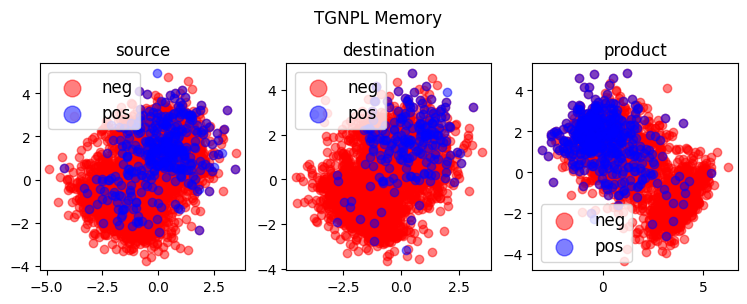

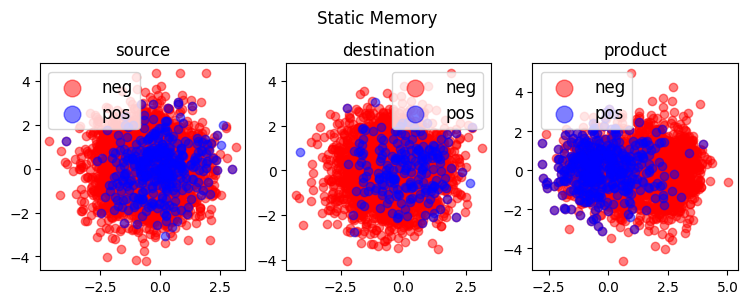

In [55]:
# Q2: How separable are pos vs neg samples of validation set using TGNPL vs static memory? 
# Obs: TGNPL memories seems to be off-center compared to static memories
# Obs: Both models are able to (slightly) distinguish product vs company nodes 

def plot_memory(negs, poss, pca_proj, title=""):
    fig = plt.figure(figsize=(9, 3))
    gs = gridspec.GridSpec(1,3)
    axes = [fig.add_subplot(gs[0,i]) for i in range(3)]
    plt.suptitle(title)
    subtitles = ['source', 'destination', 'product']

    # Iterate to plot src, prod, dst
    for i, (neg, pos) in enumerate(zip(negs, poss)):
        neg = list(map(int, neg.unique()))
        pos = list(map(int, pos.unique()))
        axes[i].scatter(pca_proj[neg, 0], pca_proj[neg, 1], 
                       c='red', label ='neg', alpha=0.5)
        axes[i].scatter(pca_proj[pos, 0], pca_proj[pos, 1], 
                       c='blue', label ='pos', alpha=0.5)
        axes[i].legend(fontsize='large', markerscale=2)
        axes[i].set_title(subtitles[i])
        
    fig.subplots_adjust(top=0.80)
    plt.show()

for batch in tqdm(val_loader):
    # Load in positive and negative samples, copied from tgnpl.py
    pos_src, pos_prod, pos_dst, pos_t, pos_msg = batch.src, batch.prod, batch.dst, batch.t, batch.msg
    neg_batch_list = neg_sampler.query_batch(pos_src, pos_prod, pos_dst, pos_t, split_mode='val')
    neg_batch_list = torch.Tensor(neg_batch_list)
    ns_samples = neg_batch_list.size(1) // 3  # num negative samples per src/prod/dst
    neg_src = neg_batch_list[:, :ns_samples]   # we assume neg batch is ordered by neg_src, neg_prod, neg_dst
    neg_prod = neg_batch_list[:, ns_samples:(2*ns_samples)]  
    neg_dst = neg_batch_list[:, (2*ns_samples):]
    print()

# Visualize the last batch of data (o/w too crowded), similar trend appears for other batches
# TGNPL Memory
plot_memory([neg_src, neg_dst, neg_prod], 
            [pos_src, pos_dst, pos_prod], 
            tgnpl_pca_proj, "TGNPL Memory")

# Static Memory
plot_memory([neg_src, neg_dst, neg_prod], 
            [pos_src, pos_dst, pos_prod], 
            static_pca_proj, "Static Memory")

In [78]:
# Addl: extra info on the batch that we worked with above
print("...Counting number of unique vs all...")
print("Source", len(neg_src.unique()), len(neg_src) * len(neg_src[0]))
print("Product", len(neg_prod.unique()), len(neg_prod) * len(neg_prod[0]))
print("Destination", len(neg_dst.unique()), len(neg_dst) * len(neg_dst[0]))

print("...Counting overlap between source and destination...")
print(len(set(list(map(int, neg_src.unique()))) & set(list(map(int, neg_dst.unique())))))

...Counting number of unique vs all...
Source 3443 5946
Product 2168 5946
Destination 2931 5946
...Counting overlap between source and destination...
1397


In [ ]:
# Remaning questions
# Does this memory changer after GraphAttention Layer (if applicable) and Linear layer? 
# Evaluating how the memory is changing with the memory updates.
# What is the loss landscape?